<a href="https://colab.research.google.com/github/HanenEl/Elevvo-Internship/blob/main/Task3%3A%20Customer%20Segmentation%20Using%20RFM%20Analysis/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
df = pd.read_csv('/content/online_retail_II.csv')

In [3]:
# Show random rows from the dataset
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
19348,490978,21912,VINTAGE SNAKES & LADDERS,1.0,2009-12-08 16:43:00,3.75,17329.0,United Kingdom
17094,490745,22283,6 EGG HOUSE PAINTED WOOD,2.0,2009-12-07 18:02:00,16.48,NaN,United Kingdom
16589,490741,21537,RETRO SPOTS PUDDING BOWL,1.0,2009-12-07 17:56:00,8.65,NaN,United Kingdom
11963,490353,21069,VINTAGE BILLBOARD TEA MUG,6.0,2009-12-04 16:37:00,1.25,15514.0,United Kingdom
19239,490966,21796,SET OF 3 RED STRIPE BASKETS,3.0,2009-12-08 16:20:00,12.75,17178.0,United Kingdom


In [4]:
# Number of Rows & Coulmns
df.shape

(23472, 8)

In [5]:
# Checking Duplicated Data
df.duplicated().sum()

np.int64(246)

In [6]:
# Removing Duplicated Data
df = df.drop_duplicates()

In [7]:
# Display Info About Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23226 entries, 0 to 23471
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      23226 non-null  object 
 1   StockCode    23226 non-null  object 
 2   Description  23178 non-null  object 
 3   Quantity     23225 non-null  float64
 4   InvoiceDate  23225 non-null  object 
 5   Price        23225 non-null  float64
 6   Customer ID  17070 non-null  float64
 7   Country      23225 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.6+ MB


In [8]:
# Display summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,23225.0,8.766932,69.919954,-1043.0,1.00,3.00,8.00,5184.00
Price,23225.0,4.270043,22.345668,0.0,1.25,2.57,4.95,1998.49
Customer ID,17070.0,15460.875571,1642.721074,12349.0,14107.00,15484.00,16891.00,18287.00


##Cleanning

In [9]:
# Change the column 'InvoiceDate' from object type to datetime type.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Change the column 'Customer ID' from Float type to int.
df['Customer ID'] = df['Customer ID'].astype('Int64')

# Remove rows with negative Quantity or UnitPrice
df = df[(df['Quantity'] > 0)]

# Create TotalPrice column for each transaction
df['TotalPrice'] = df['Quantity'] * df['Price']


In [10]:
# Check for missing values
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,20
Quantity,0
InvoiceDate,0
Price,0
Customer ID,6110
Country,0
TotalPrice,0


In [11]:
# Remove missing values
df.dropna(subset=['Customer ID', 'Description'], inplace=True)

##RFM Analysis

In [12]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


In [13]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4,labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4,labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4,labels=[1,2,3,4])

rfm['RFM_Segment'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm['RFM_Score'] = (
    rfm[['R_Score','F_Score','M_Score']]
    .astype(int)
    .sum(axis=1)
)

In [14]:
def segment_me(x):
    if x >= 10:
        return 'Loyal'
    elif x >= 8:
        return 'Active'
    elif x >= 6:
        return 'Regular'
    else:
        return 'At Risk'
rfm['Segment'] = rfm['RFM_Score'].apply(segment_me)

In [15]:
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
Customer ID,,,,,,,,,
12358,3,1,1429.83,4,1,4,414,9,Active
12359,6,1,760.69,2,1,4,214,7,Regular
12362,10,1,130.00,1,1,1,111,3,At Risk
12417,1,2,317.60,4,4,3,443,11,Loyal
12435,9,1,1008.00,1,1,4,114,6,Regular


##Visualization

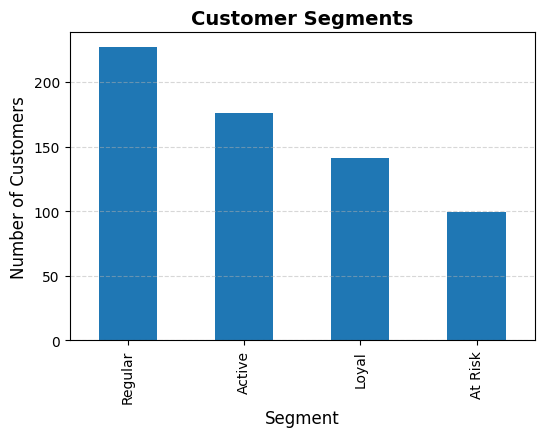

In [16]:
# Customer Segments by bar Plot
rfm['Segment'].value_counts().plot(kind='bar', figsize=(6,4))

plt.title("Customer Segments", fontsize=14, fontweight='bold')
plt.xlabel("Segment",fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

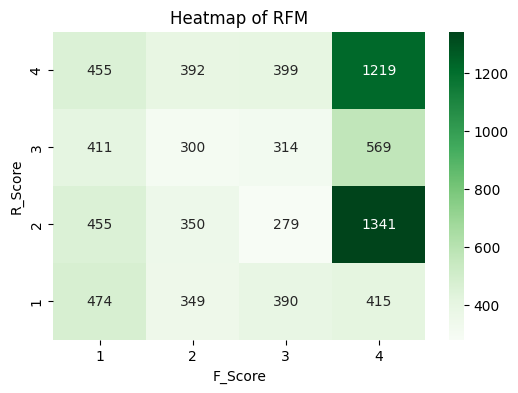

In [17]:
# Customer Segments by heatmap
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean')

plt.figure(figsize=(6,4))
sns.heatmap(rfm_pivot, annot=True, fmt=".0f", cmap="Greens")
plt.title("Heatmap of RFM")
plt.show()